<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_1_Bab_3_3_7_Menggunakan_Learning_Rate_Annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam, lr_scheduler
# More optimizer: https://pytorch.org/docs/stable/optim.html#algorithms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [2]:
data_folder = './data/FMNIST'

train_data = datasets.FashionMNIST(data_folder, download=True, train=True)
val_data = datasets.FashionMNIST(data_folder, download=True, train=False)

tr_images, tr_targets = train_data.data, train_data.targets
val_images, val_targets = val_data.data, val_data.targets

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



In [3]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [4]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.01)   # Optimizer & Learning Rate
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [5]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
learning_rates = []

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0, threshold=0.001, verbose=True, min_lr=0.00001, threshold_mode='abs')

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []

    # Pelatihan pada data pelatihan
    for x, y in trn_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x, y in trn_dl:
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Evaluasi pada data validasi
    for x, y in val_dl:
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    scheduler.step(validation_loss)

    current_lr = scheduler.optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    print(f"Current Learning Rate: {current_lr:.6f}")

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1
Current Learning Rate: 0.010000
Train Loss: 0.5402, Train Accuracy: 0.8357
Validation Loss: 0.5079, Validation Accuracy: 0.8239
Epoch 2
Current Learning Rate: 0.010000
Train Loss: 0.4344, Train Accuracy: 0.8538
Validation Loss: 0.4762, Validation Accuracy: 0.8384
Epoch 3
Current Learning Rate: 0.005000
Train Loss: 0.4110, Train Accuracy: 0.8544
Validation Loss: 0.4839, Validation Accuracy: 0.8378
Epoch 4
Current Learning Rate: 0.005000
Train Loss: 0.3483, Train Accuracy: 0.8807
Validation Loss: 0.4060, Validation Accuracy: 0.8562
Epoch 5
Current Learning Rate: 0.002500
Train Loss: 0.3375, Train Accuracy: 0.8840
Validation Loss: 0.4071, Validation Accuracy: 0.8599
Epoch 6
Current Learning Rate: 0.002500
Train Loss: 0.3080, Train Accuracy: 0.8890
Validation Loss: 0.3934, Validation Accuracy: 0.8651
Epoch 7
Current Learning Rate: 0.001250
Train Loss: 0.3008, Train Accuracy: 0.8892
Validation Loss: 0.3959, Validation Accuracy: 0.8630
Epoch 8
Current Learning Rate: 0.001250
Train Lo

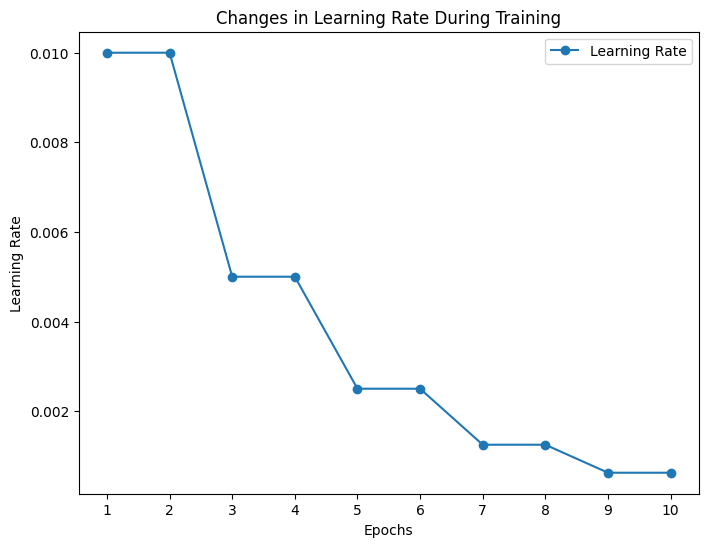

In [8]:
epochs = np.arange(10) + 1

plt.figure(figsize=(8, 6))

plt.plot(epochs, learning_rates, marker='o', linestyle='-', label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Changes in Learning Rate During Training')
plt.xticks(epochs)
plt.legend()

plt.show()

<ipython-input-9-b5949db202af>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


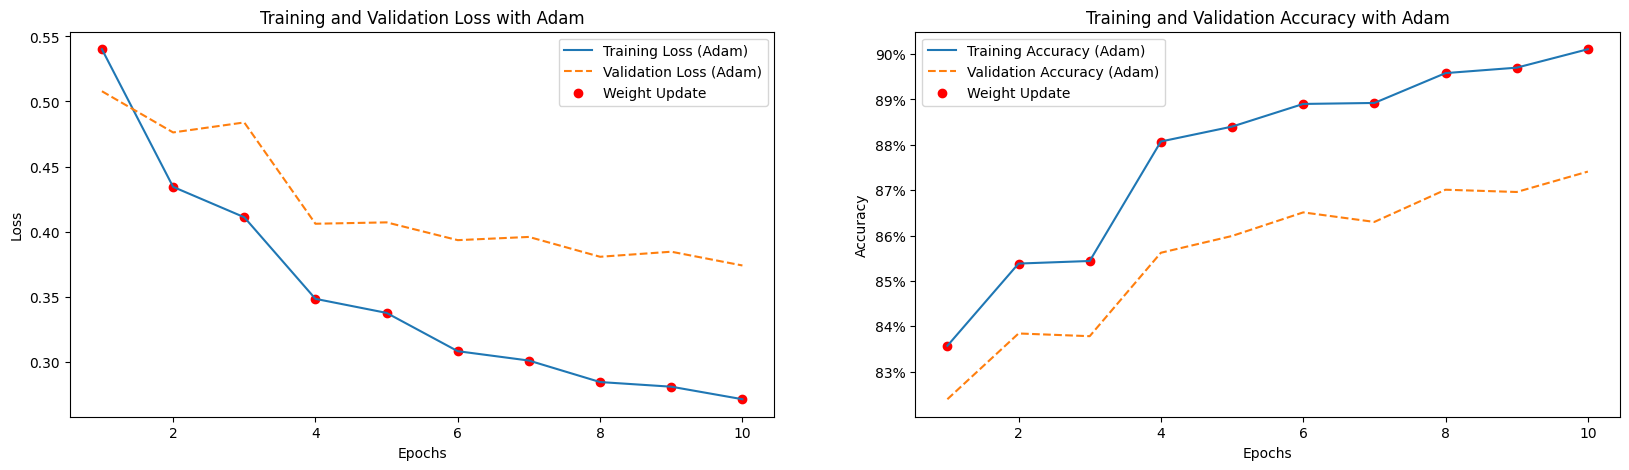

In [9]:
epochs = np.arange(10) + 1

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss (Adam)')
plt.plot(epochs, val_losses, label='Validation Loss (Adam)', linestyle='--')
plt.scatter(epochs, train_losses, color='red', label='Weight Update')
plt.title('Training and Validation Loss with Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy (Adam)')
plt.plot(epochs, val_accuracies, label='Validation Accuracy (Adam)', linestyle='--')
plt.scatter(epochs, train_accuracies, color='red', label='Weight Update')
plt.title('Training and Validation Accuracy with Adam')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()